# 最好的卷积层超参数

- 到底用哪种卷积核比较好？
<img src="./pic/最好的卷积层超参数.PNG" width=400 height=400>


# GoogLeNet中的Inception块
- 小学生才做选择题，我全要了
- 在每个Inception块里，4个路径从不同层面抽取信息，然后在输出通道维，在通道上合并（堆叠，通道数相加）
    - input被复制了4份，每条路径一份input
    - 输入与输出的高宽不变，输出的通道数变多
<img src="./pic/Inception块.PNG" width=400 height=400>


## Inception块
- 3x3卷积层：从192降到96是为了降低模型复杂度
- 5x5卷积层：因为5x5更贵，所以降得更多
- 白色的1x1是只用来降低通道数，不改变高宽
- 蓝色的卷积层是用来抽取信息
    - 蓝色的1x1卷积层：不抽取空间信息，只抽取通道信息
    - 蓝色的其他卷积层（包括maxpooling，使得更加鲁棒）：抽取空间信息
- 输出通道：64 + 128 + 32 + 32 = 256 
    - 128：抽取出的空间信息，相对重要
    - 64：不看空间信息，只看通道信息
    - 剩下64对半分
    - 以上数值都是调参调出来的，没有依据
<img src="./pic/Inception第一块.PNG" width=400 height=400>


## 参数量与计算复杂度
- 跟单3x3或5x5卷积层比，Inception块有更少的参数个数核计算复杂度
<img src="./pic/参数量与计算复杂度.PNG" width=400 height=400>


## GoogLeNet架构
- 由5段，9个Inception块组成，与VGG块类似
- 高宽减半就是1个stage
- Inception块不改变高宽，只该改变通道数
- 使用了大量的1x1卷积，降低通道数
- 做完全局平均池化后，得到一个长为通道数的向量
- 最后通过FC层，映射到标号所在的类别数
<img src="./pic/GoogLeNet架构.PNG" width=400 height=400>


## Stage 1&2
- Conv1: (224 - 7 + 3 x 2 + 2) / 2 = 112
- MaxP1: (112 - 3 + 1 x 2 + 2) / 2 = 56
- Conv2: (56 - 1 + 1) / 1 = 56
- Conv3: (56 - 3 + 1 x 2 + 1) / 1 = 56
- MaxP2: (56 - 3 + 1 x 2 + 2) / 2 = 28
- 更小的image高宽和更多的通道数，使后面的计算复杂度降低
<img src="./pic/Stage 1&2.PNG" width=400 height=400>


## Stage 3
- 通道数由192变成480，经过最后一层max pooling后，高宽减半
- 两个Inception块的通道数并不一样（现阶段无规律可言）
<img src="./pic/Stage 3.PNG" width=400 height=400>


## Stage 4&5
<img src="./pic/Stage 4&5.PNG" width=400 height=400>


## Inception 有各种后续变种
<img src="./pic/Inception 有各种后续变种.PNG" width=400 height=400>


## Inception V3 stage3
<img src="./pic/Inception V3 stage3.PNG" width=400 height=400>

## Inception V3 stage4
<img src="./pic/Inception V3 stage4.PNG" width=400 height=400>

## Inception V3 stage5
<img src="./pic/Inception V3 stage5.PNG" width=400 height=400>

## Inception V3 预测精度
- 圆圈的大小代表所占用的内存大小
- V3计算慢，耗内存，但精度高
<img src="./pic/Inception V3 精度.PNG" width=400 height=400>


## 总结
- Inception块用4条有不同超参数的卷积层和池化层的路，来抽取不同的信息
    - 它的一个主要优点是模型参数小，计算复杂度低
- GoogLeNet使用了9个Inception块，是第一个达到上百层的网络（并行通道，非深度）
    - 每个块里有6个卷积层，9块有54个卷积层
    - 后续有一系列改进

# GoogleNet代码实现

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):    # **kwargs是将除了前面显式列出的参数外的其他参数, 以dict结构进行接收.
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)    # 在输出通道数的维度，把通道数concat起来（dim=0为批量）

## 逐一实现GoogLeNet的每个模块。
- 第一个模块使用64个通道、 7×7 卷积层。

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

- 第二个模块使用两个卷积层：第一个卷积层是64个通道、 1×1 卷积层；第二个卷积层使用将通道数量增加三倍的 3×3 卷积层。 这对应于Inception块中的第二条路径。

In [4]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

- 第三个模块串联两个完整的Inception块。 
    - 第一个Inception块的输出通道数为 64+128+32+32=256 ，四个路径之间的输出通道数量比为 64:128:32:32=2:4:1:1 。 
    - 第二个和第三个路径首先将输入通道的数量分别减少到 96/192=1/2 和 16/192=1/12 ，然后连接第二个卷积层。
    - 第二个Inception块的输出通道数增加到 128+192+96+64=480 ，
    - 四个路径之间的输出通道数量比为 128:192:96:64=4:6:3:2 。 
    - 第二条和第三条路径首先将输入通道的数量分别减少到 128/256=1/2 和 32/256=1/8 。

In [5]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

- 第四模块更加复杂， 它串联了5个Inception块，其输出通道数分别是 
    - 192+208+48+64=512 、 
    - 160+224+64+64=512 、 
    - 128+256+64+64=512 、 
    - 112+288+64+64=528 和 
    - 256+320+128+128=832 。 
- 这些路径的通道数分配和第三模块中的类似，
    - 首先是含 3×3 卷积层的第二条路径输出最多通道，
    - 其次是仅含 1×1 卷积层的第一条路径，
    - 之后是含 5×5 卷积层的第三条路径和
    - 含 3×3 最大汇聚层的第四条路径。 
    - 其中第二、第三条路径都会先按比例减小通道数。 
    - 这些比例在各个Inception块中都略有不同。

In [6]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

- 第五模块包含输出通道数为 256+320+128+128=832 和 384+384+128+128=1024 的两个Inception块。 
- 其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。 - 需要注意的是，第五模块的后面紧跟输出层，该模块同NiN一样使用全局平均汇聚层，将每个通道的高和宽变成1。 
- 最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。

In [7]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())    # 输出长为1024的向量

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

### 为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96，这简化了计算。下面演示各个模块输出的形状变化。

In [8]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


C:\Users\Tyler\anaconda3\envs\pytorch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 训练模型
- 将图片转换为 96×96 分辨率

loss 0.248, train acc 0.906, test acc 0.880
2141.9 examples/sec on cuda:0


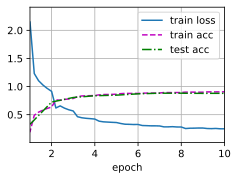

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())